In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from qutip import *
class o:pass

#### 1. problem setup
This script aims to display a novel model describing an excitonic two-level system of a single QD inside a nanocavity. 

This model is one that stems from the basic Jaynes-Cummings (JC) model. On top of the QD-cavity coupling the JC model describes, the model also includes an additional laser field to diretcly pump the single QD simultaneously. This gives a Hamiltonian as shown:


$$

    \hat{H} = \omega_c \hat{a}^{\dagger} \hat{a}
    + \omega_a \hat{\sigma}_{ee}
    + g \left( \hat{a}^{\dagger} \hat{\sigma}_{ge} + \hat{a} \hat{\sigma}_{eg} \right)
    + \eta \left( \hat{a}e^{i \omega_p t} + \hat{a}^{\dagger} e^{-i \omega_p t} \right)
    + \Omega \left( e^{i(\omega_L t + \theta)} \hat{\sigma}_{ge} + e^{-i(\omega_L t + \theta)} \hat{\sigma}_{eg} \right)

$$

where:
- for the single-mode nanocavity along x-axis:
    - $\omega_c$ is the cavity frequency
    - $g$ is the QD-cavity coupling strength
    - $\kappa$ is the cavity decay rate
- for the driving field:
    - $\omega_p$ is the frequency of the driving weak laser field
    - $\eta$ is the coupling strength 
- for the additional pump field along y-axis:
    - $\omega_L$ is the pumping frequency
    - and $\theta$ is the relative phase between QD pumping field and cavity driven field who plays a significant role in the photon blockade effect. 

For simplicity, we now assume that $ \omega_p = \omega_L $ and $ \omega_c = \omega_a $. Utilizing a unitary transformation, the interaction Hamiltonian can be rewritten as:

$$
    \hat{H}_{int} = \Delta_c \hat{a}^{\dagger}\hat{a} + \Delta_c \hat{\sigma}_{ee} 
    + g \left( \hat{a}^{\dagger} \hat{\sigma}_{ge} + \hat{a} \hat{\sigma}_{eg} \right)
    + \eta \left( \hat{a} + \hat{a}^{\dagger} \right)
    + \Omega \left( e^{i\theta} \hat{\sigma}_{ge} + e^{-i\theta} \hat{\sigma}_{eg} \right)
$$

where $ \Delta_c = \omega_c - \omega_p = \omega_a - \omega_L $ is the cavity-light detuning. 

We are also interested in the quantum statistics of the photon field. Therefore, we want to calculate the second order correlation function:
$$
    g^{(2)}(0) = \langle \hat{a}^{\dagger} \hat{a}^{\dagger} \hat{a} \hat{a} \rangle 
    / \langle \hat{a}^{\dagger} \hat{a} \rangle ^2
$$

#### 1.1 Figure 2
#### 1.1.1 Problem Parameters


In [7]:
def operators(kappa, gamma, N):
    # input: various parameters 
    # output: a dictionary of joint operators for the system

    # Anhilation Operators
    a  = tensor(destroy(N), qeye(2))    # a - cavity lowering operator
    sm = tensor(qeye(N), sigmam())    # sigma - atomic lowering operator

    # Collapse Operators
    C1 = np.sqrt(2*kappa)*a
    C2 = np.sqrt(gamma)*sm
    C1dC1 = C1.dag() * C1
    C2dC2 = C2.dag() * C2

    return locals()

def Hamil( g, eta, Omega, Del_c, theta, ge, a ):
    # input: relevant parameters and operators
    # output: Hamiltonian operator

    H0 = Del_c * a.dag() * a + Del_c * ge.dag() * ge
    H1 = (a.dag() * ge + a * ge.dag()) 
    H2 = (a + a.dag())
    H3 = (np.exp(1j*theta) * ge + np.exp(-1j*theta) * ge.dag()) 

    H = H0 + g * H1 + eta * H2 + Omega * H3

    return H

def Liouv( H, C1, C2, C1dC1, C2dC2 ):
    # input: relevant operators and Hamiltonian
    # output: Liouvillian
    LH = -1j * (spre(H) - spost(H))
    L1 = spre(C1)*spost(C1.dag()) - 0.5*spre(C1dC1) - 0.5*spost(C1dC1)
    L2 = spre(C2)*spost(C2.dag()) - 0.5*spre(C2dC2) - 0.5*spost(C2dC2)

    L = LH+L1+L2
    return L 

def correlation_ss_gtt(H, tlist, c_ops, a_op, b_op, c_op, d_op, rho0=None):
    if rho0 == None:
        rho0 = steadystate(H, c_ops)

    return mesolve(H, d_op * rho0 * a_op, tlist, c_ops, [b_op * c_op]).expect[0]

In [8]:
## PARAMETERS ##
kappa = 20*2*np.pi      # cavity dissipation rate (GHz)
gamma = 2*np.pi         # atom dissipation rate (GHz)
N = 5                  # number of cavity fock states 
taulist = np.linspace(0,10.0,200)

g  = 2*kappa        # QD-cavity coupling strength
eta = 0.1*kappa     # weak cavity coupling strength
Omega = 0.124*g     # pump field coupling strength

## OPERATORS ##
# pack operators into a dictionary
op_dict = operators(kappa, gamma, N)
# assign dictionary items as attributes of class 'o' (operators)
for k,v in op_dict.items():
    setattr(o, k, v)

## ARRAYS FOR PLOTTING ##
theta_vec = np.array([0.082, 1-0.082])*np.pi
Del_c_vec = np.linspace(-2,2,201) * g
count_lst = []
g2_lst = []

## CALCULATION ##
for theta in theta_vec:
    count_vec = []
    g2_vec = []
    for Del_c in Del_c_vec:
        H = Hamil( g, eta, Omega, Del_c, theta, o.sm, o.a )
        L = Liouv( H, o.C1, o.C2, o.C1dC1, o.C2dC2 )
        rhoss = steady(L)

        n = expect(o.C1dC1,rhoss)

        G2 = correlation_ss_gtt(H, taulist, [o.C1,o.C2], o.a.dag(), o.a.dag(), o.a, o.a, rho0=rhoss)
        g2 = G2 / n**2

        count_vec.append(n)
        g2_vec.append(g2)
    
    g2_lst.append(g2_vec)
    count_lst.append(count_vec)

Omega = 0 

Ome0count_vec = []
Ome0g2_vec = []
for Del_c in Del_c_vec:
    H = Hamil( g, eta, Omega, Del_c, theta, o.sm, o.a )
    L = Liouv( H, o.C1, o.C2, o.C1dC1, o.C2dC2 )
    rhoss = steady(L)

    n = expect(o.C1dC1,rhoss)

    G2 = correlation_ss_gtt(H, taulist, [o.C1,o.C2], o.a.dag(), o.a.dag(), o.a, o.a, rho0=rhoss)
    g2 = G2 / n**2

    Ome0count_vec.append(n)
    Ome0g2_vec.append(g2)
    

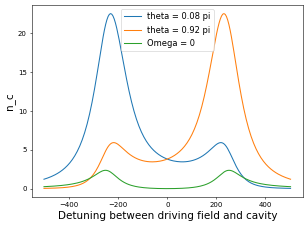

In [9]:
fig1, ax1 = plt.subplots(1, 1, figsize=(7,5), dpi=50)
i=0
for theta in theta_vec:
    ax1.plot(Del_c_vec, count_lst[i], label = 'theta = {:.2f} pi'.format(theta/np.pi))
    i += 1

ax1.plot(Del_c_vec, Ome0count_vec, label = 'Omega = 0')

ax1.set_xlabel('Detuning between driving field and cavity', fontsize = 15)
ax1.set_ylabel('n_c', fontsize = 15)
ax1.legend(fontsize = 12)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


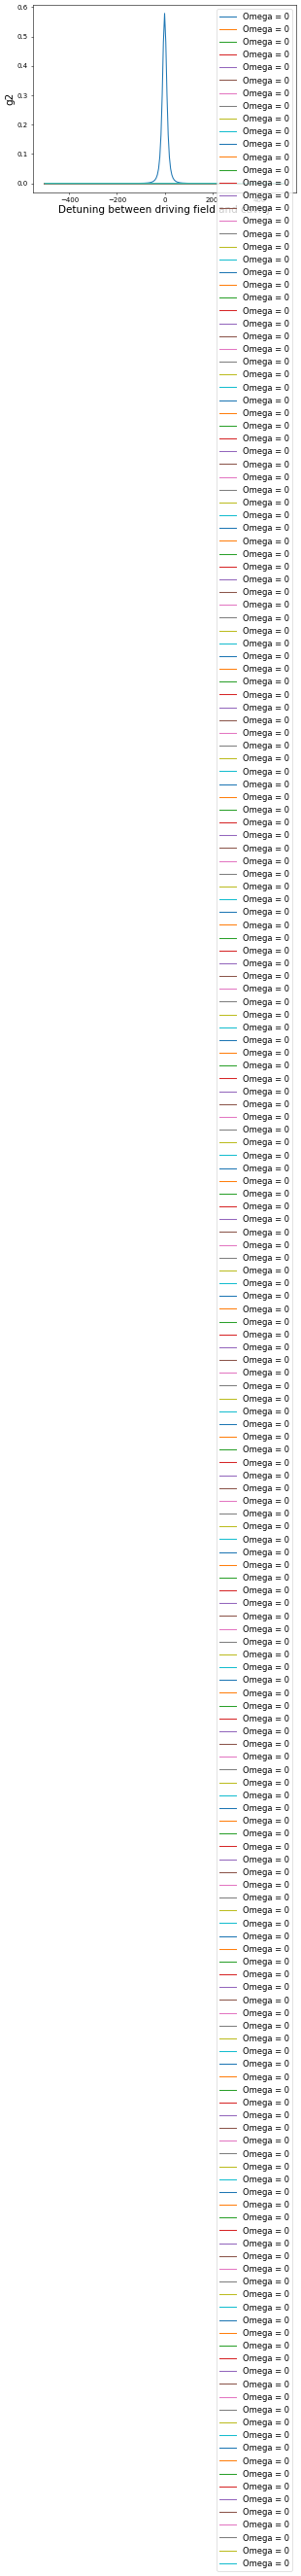

In [10]:
fig2, ax2 = plt.subplots(1, 1, figsize=(7,5), dpi=50)
i=0
for theta in theta_vec:
    ax1.plot(Del_c_vec, g2_lst[i], label = 'theta = {:.2f} pi'.format(theta/np.pi))
    i += 1

ax2.plot(Del_c_vec, Ome0g2_vec, label = 'Omega = 0')

ax2.set_xlabel('Detuning between driving field and cavity', fontsize = 15)
ax2.set_ylabel('g2', fontsize = 15)
ax2.legend(fontsize = 12)